In [8]:
import gym
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from IPython.display import clear_output
from matplotlib import pyplot as plt

from timeit import default_timer as timer
from datetime import timedelta
import math
import random

In [9]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
def plot(frame_idx, rewards, losses, sigma, elapsed_time):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(121)
    plt.title('frame %s. reward: %s. time: %s' % (frame_idx, np.mean(rewards[-10:]), elapsed_time))
    plt.plot(rewards)
    if losses or sigma:
        plt.subplot(122)
        plt.title('fidelity')
    if losses:
        plt.plot(losses, 'g')
    if sigma:
        plt.plot(sigma, 'r')
    plt.show()

In [11]:
# (action, reward) distribution for a given "spectator measurement outcome" state
class Context:
    def __init__(self, num_arms, gamma):
        # correspondingly indexed (reward | state, action) set
        # samples from beta(S, F) distribution
        self.reward_posterior_samples = np.ones(num_arms, dtype=np.float64)
        # (successes | arm)
        self.S = np.ones(num_arms, dtype=np.int)
        # (failures | arm)
        self.F = np.ones(num_arms, dtype=np.int)
        # discount factor
        self.gamma = gamma

        self.num_arms = num_arms

    def reset(self):
        self.S = np.ones(self.num_arms, dtype=np.int)
        self.F = np.ones(self.num_arms, dtype=np.int)

    def update_gamma(self, gamma):
        self.gamma = gamma

    def resample_rewards(self):
        # ("Thompson") sampling from beta(S, F) distribution for each arm
        # which enables exploration
        for i in range(len(self.reward_posterior_samples)):
            self.reward_posterior_samples[i] = np.random.beta(self.S[i], self.F[i])

    def discount(self):
        self.S = self.gamma * self.S
        self.F = self.gamma * self.F

    def update_posterior(self, reward, max_reward, arm):
        self.discount()
        # should be in terms of width instead of fixed pi/2
        self.S[arm] += reward
        self.F[arm] += max_reward - reward

In [12]:
# contextual Thompson Sampling algorithm implementation
class TS:
    def __init__(self, env, initial_gamma=0.99):
        # two contexts -> pos vs neg rotation with respect to a chosen rotational bias
        self.contexts = [Context(env.num_arms, initial_gamma), Context(env.num_arms, initial_gamma)]

        self.rewards = []
        self.fidelity = []
        self.control_fidelity = []

        self.num_context_spectators = env.num_context_spectators
        self.num_reward_spectators = env.num_reward_spectators

        self.action_distribution_width = np.pi / 2
        self.action_contextual_bias = 0

    def get_actions(self, observations):
        # our context is an array of binary spectator qubit measurements
        # hence, we could convert this binary array to an integer and index 2^(spectator qubits) contexts
        # context = self.contexts[np.packbits(observation, bitorder='little')[0]] 
        # for now, we only have two contexts (+ vs -), and so we consider spectators to be indistinguishable noise polling devices
        # in the future, we may consider noise gradients and so we do indeed need to track the specific arrangement

        actions = []
        for observation in observations:
            context_idx = 1 if np.sum(observation) > self.num_context_spectators / 2 else 0
            context = self.contexts[context_idx]
            context.resample_rewards()

            ## to update the gamma or action space, use the functions below e.g. _update_action_distribution_width
            ## this will ensure that the contextual history is reset once the historical correspondence between arms and particular thetas is nullified

            # (quantile, uniform action distribution width, rotational bias)
            actions.append((np.argmax(context.reward_posterior_samples), self.action_distribution_width, self.action_contextual_bias))
        return actions

    def _update_gammas(self, gamma):
        for context in self.contexts:
            context.update_gamma(gamma)

    def _update_action_distribution_width(self, width):
        self.action_distribution_width = width
        for context in self.contexts:
            context.reset()

    def _update_contextual_bias(self, bias):
        self.update_contextual_bias = bias
        for context in self.contexts:
            context.reset()

    def update(self, actions, rewards, observations):
        for action, reward, observation in zip(actions, rewards, observations):
            arm, _, _ = action
            context_idx = 1 if np.sum(observation) > self.num_context_spectators / 2 else 0
            context = self.contexts[context_idx]
            context.update_posterior(reward, self.num_reward_spectators, arm)

    def save_reward(self, reward):
        self.rewards.append(reward)

    def save_fidelity(self, fidelity):
        self.fidelity.append(fidelity)

    def save_control_fidelity(self, fidelity):
        self.control_fidelity.append(fidelity)

In [13]:
M = 100
BATCH_SIZE = 10



# add some random harmonics
# time_dependent_fn = np.vectorize(lambda x: (2/5) * np.pi * np.sin(2 * np.pi * x / M))
# error_samples = np.random.normal(0, np.pi / 4, M) # + time_dependent_fn(np.arange(M))
error_samples = np.random.choice([-np.pi/4, np.pi / 4], M)

In [18]:
from spectator_env import SpectatorEnvDiscrete

# describes MDP
# - states are given in terms of a 64 bit measurement outcomes
# - action space is given by (num_arms, uniform_action_space_width, contextual_measurement_bias) i.e. \ZZ_{num_arms} \times U(1) \times U(1)
env = SpectatorEnvDiscrete(error_samples, batch_size=BATCH_SIZE, num_context_spectators=64, num_reward_spectators=64, num_arms=5)

# from stable_baselines.common.env_checker import check_env
# check_env(env)

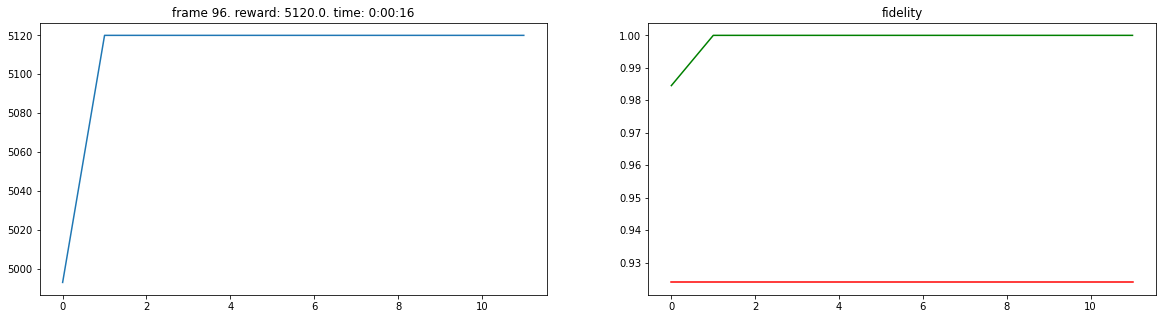

In [19]:
start = timer()

ts = TS(env, initial_gamma=1.0)

episode_reward = 0
episode_fidelity = []
control_fidelity = []

MAX_FRAMES = 10 * M // BATCH_SIZE

# "episodes" are a reasonable way to think about learning a periodic time dependent function
# max frames = episode length * num episodes
# episodes are identical sequences of training data
observation = env.reset()
# print(observation)
for frame_idx in range(1, MAX_FRAMES + 1):
    # epsilon = config.epsilon_by_frame(frame_idx)

    actions = ts.get_actions(observation)
    prev_observation=observation
    # print("prev obs: ", prev_observation)
    # print("action: ", action)
    observation, reward, done, info = env.step(actions)
    # print("done: ", done)
    # print("reward: ", reward)
    observation = None if done else observation

    # generally, in RL we would consider r(s | s', a)
    # given a state transition s' -> s due to action a
    # for now, we are only interested in r(s', a)
    ts.update(actions, reward, prev_observation)
    # print(ts.contexts[0].S, ts.contexts[0].F)
    # print(ts.contexts[1].S, ts.contexts[1].F)
    episode_reward += np.sum(reward)

    for x, y in info:
        episode_fidelity.append(x)
        control_fidelity.append(y)
    if done:
    # new_error_samples = np.random.normal(0, np.pi / 4, M)
    # env.set_error_samples(new_error_samples)
        print(done)
        observation = env.reset()
        ts.save_reward(episode_reward)
        ts.save_fidelity(np.mean(episode_fidelity))
        ts.save_control_fidelity(np.mean(control_fidelity))
        episode_reward = 0
        episode_fidelity = []
        control_fidelity = []

        # plot grouped by episode
        plot(frame_idx, ts.rewards, ts.fidelity, ts.control_fidelity,
    timedelta(seconds=int(timer()-start)))

env.close()


In [9]:
print(ts.contexts[0].S, ts.contexts[0].F)
print(ts.contexts[0].reward_posterior_samples)

[2.5537e+04 6.2000e+01 1.0100e+02 1.0000e+00 3.0000e+01] [ 1.  4. 29.  1. 36.]
[0.99999092 0.95935985 0.74299357 0.67880241 0.49542634]


In [10]:
print(ts.contexts[1].S, ts.contexts[1].F)
print(ts.contexts[1].reward_posterior_samples)

[3.0000e+01 4.2000e+01 5.2000e+01 1.0000e+00 3.8017e+04] [36. 24. 14.  1.  1.]
[0.53691944 0.64758189 0.83181447 0.62142533 0.99996642]
